In [1]:
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pytorchtools import EarlyStopping
import math
from tqdm import tqdm

#### Numpy & Python Version 확인

In [2]:
import numpy as np
import platform

# NumPy 버전 확인
numpy_version = np.__version__

# Python 버전 확인
python_version = platform.python_version()

print(f"NumPy 버전: {numpy_version}")
print(f"Python 버전: {python_version}")

NumPy 버전: 1.24.3
Python 버전: 3.11.9


#### CUDA 사용 및 EarlyStopping 설정

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)
early_stopping = EarlyStopping(patience = 5, verbose = True)

cuda:0


#### 모델 저장

In [5]:
def saveModel():
    torch.save(model.state_dict(), 'model_lstm_autoencoder_AR(2).pt') # 모델의 학습된 매개변수 파일에 저장

#### 하이퍼 파라미터 설정

In [6]:
# 하이퍼파라미터 설정
length = 12            # 윈도우 사이즈 (생성할 시계열 데이터의 길이)
trainrun = 200       # 생성할 학습 데이터 시퀀스의 수 
validrun = 100         # 생성할 검증 데이터 시퀀스의 수 

# 시계열 데이터 생성을 위한 매개변수
# 자기상관계수 (phi1, phi2별로 생성)
phi1 = np.array([0, 0.25, 0.4, 0.6, 0.8])
phi2 = np.array([0.1, 0.2, 0.3, 0.2, 0.1])

# 변화율 크기
psi1 = 0

# 공정의 수준 변화율 (delta)
de1 = 0

# 공정의 분산 변화율 (gamma)
ga = 1

#### 시계열 데이터 생성

In [7]:
np.random.seed(1)

# AR(2) 시계열 데이터 생성 함수
def ar2(phi1, phi2, delta, gamma, psi, length, run):
    # 초기 설정
    y = np.zeros(shape=(run, length))                                                         # 생성될 시계열 데이터를 저장할 빈 배열을 초기화. 배열의 크기는 (생성할 데이터 시퀀스의 수, 각 시퀀스의 길이) 
    sigma = math.sqrt((1 - phi2) / ((1 + phi2) * (1 - phi2 - phi1) * (1 - phi2 + phi1)))     # AR(2)모델의 표준 편차
    
    # 데이터 시퀀스 생성
    for j in range(0, run):                                     # 각 run 마다 랜덤 노이즈(e)를 정규분포에서 추출하여 시계열의 기본 노이즈 생성 (과적합 방지 차원)
        e = np.random.normal(loc=0, scale=1, size=length)       
        x = np.zeros(length)
        
        x[0] = e[0]                                             # x 배열 초기화하고, 첫 번째 시점의 값은 첫 번째 노이즈 값으로 설정 (시계열의 시작점에서 발생할 수 있는 임의성 반영 및 자기상관 구조 구현)

        # psi 시점 이전의 데이터 생성
        for i in range(2, psi):                                 # psi 시점 이전까지는 관리상태 데이터
            x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i]     # AR(2)모델의 관리상태
            
        # psi 시점 이후의 데이터 생성 및 변동성 적용
        for i in range(psi,len(x)):                             # AR(2)모델의 이상상태
            e[i] = gamma * e[i]
            x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i] 
        for i in range(psi,len(x)):                             # delta(변동성 크기 조절하는 매개변수)를 통한 추가 변동성 적용
            x[i] = x[i] + delta*sigma
        
        # 최종 데이터 반환 (각 run에 대해 생성된 시계열 데이터를 저장)  
        y[j] = x

    return y



# 다양한 매개변수 조합에 대한 시계열 데이터 세트 생성
def totaldat(run,length):
    # 빈 데이터 배열 초기화
    y = np.zeros(shape=(len(phi1), run, length))
    # 매개변수 조합별 데이터 생성
    for i, (phi_1, phi_2) in enumerate(zip(phi1, phi2)):
        y[i]= ar2(phi_1, phi_2, de1, ga, psi1, length, run)

    return y.reshape(run * len(phi1), length)                 # 생성된 데이터를 적절한 형태로 재배열


In [8]:
# 훈련용 시계열 데이터
# 데이터 생성 및 변형
train_x = totaldat(trainrun,length)                             # 훈련용 시계열 데이터 생성
train_x = train_x.reshape(trainrun*len(phi1),length)            

# 검증용 시계열 데이터
# 데이터 생성 및 변형
valid_x = totaldat(run = validrun, length = length)
valid_x = valid_x.reshape(validrun*len(phi1),length)

# PyTorch 텐서로 변환 및 장치 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_x = torch.FloatTensor(train_x).to(device)
valid_x = torch.FloatTensor(valid_x).to(device)

# DataLoader 설정
trainloader = DataLoader(train_x, shuffle=True)                  # 데이터셋에서 미니배치 자동으로 생성 후 모델 학습 및 평가 시 배치 처리를 용이하게 함 (훈련에서는 데이터를 섞어 학습 과정에서의 일반화 능력 향상)
validloader = DataLoader(valid_x, shuffle=False)                # 학습 및 검증에서는 데이터 순서 유지

In [9]:
for data in trainloader:
    print(data.shape)
    break

torch.Size([1, 12])


In [10]:
len(trainloader)

1000

In [11]:
len(validloader)

500

In [12]:
train_x.shape[1]

12

#### LSTM Autoencoder 구조

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# LSTM Encoder 클래스 정의
class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(LSTMEncoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.hidden_to_latent(hidden[-1])

# LSTM Decoder 클래스 정의
class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_length):
        super(LSTMDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True)
        self.outputs_to_data = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        z = self.latent_to_hidden(z).unsqueeze(0)
        repeated_z = z.repeat(self.seq_length, 1, 1).transpose(0, 1)
        lstm_out, _ = self.lstm(repeated_z)
        return self.outputs_to_data(lstm_out)

# 전체 LSTM 오토인코더 모델
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=128, latent_dim=1):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, input_dim, seq_length)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# 모델 인스턴스 생성 및 설정
model = LSTMAutoencoder(input_dim=length, seq_length=length, hidden_dim=128, latent_dim=1)
model = model.to(device)

In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)  # You can adjust the initial lr based on your model and training needs
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

Epoch 1, Train Loss: 1.0194, Validation Loss: 1.0538
Validation loss decreased (1.055042 --> 1.053813).  Saving model ...
Epoch 2, Train Loss: 1.0183, Validation Loss: 1.0527
Validation loss decreased (1.053813 --> 1.052656).  Saving model ...
Epoch 3, Train Loss: 1.0171, Validation Loss: 1.0515
Validation loss decreased (1.052656 --> 1.051549).  Saving model ...
Epoch 4, Train Loss: 1.0160, Validation Loss: 1.0504
Validation loss decreased (1.051549 --> 1.050397).  Saving model ...
Epoch 5, Train Loss: 1.0150, Validation Loss: 1.0493
Validation loss decreased (1.050397 --> 1.049318).  Saving model ...
Epoch 6, Train Loss: 1.0140, Validation Loss: 1.0483
Validation loss decreased (1.049318 --> 1.048257).  Saving model ...
Epoch 7, Train Loss: 1.0129, Validation Loss: 1.0473
Validation loss decreased (1.048257 --> 1.047256).  Saving model ...
Epoch 8, Train Loss: 1.0119, Validation Loss: 1.0463
Validation loss decreased (1.047256 --> 1.046262).  Saving model ...
Epoch 9, Train Loss: 1.0

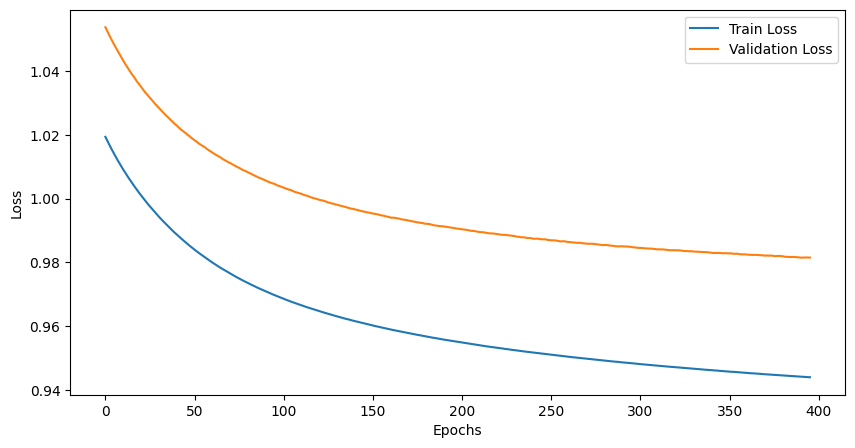

In [16]:
def training(epochs):
    loss_ = []
    valoss_ = []

    for epoch in range(epochs):
        running_train_loss = 0.0
        running_vall_loss = 0.0

        # Training process
        for data in trainloader:
            model.train()
            inputs = data                                                           # Assuming data is the input tensor
            inputs = inputs.to(device)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            train_loss = criterion(predicted_outputs, inputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = running_train_loss / len(trainloader)
        loss_.append(avg_train_loss)
        
        # Validation process
        with torch.no_grad():
            model.eval()
            for data in validloader:
                inputs = data
                inputs = inputs.to(device)
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, inputs)
                running_vall_loss += val_loss.item()

            avg_val_loss = running_vall_loss / len(validloader)
            valoss_.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        
        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
 
    # Save model
    saveModel()
    return loss_, valoss_  # Return the collected loss values for training and validation

# Now when you call training, it will return the lists to be unpacked.
loss_, valoss_ = training(epochs=400)  # Set the appropriate number of epochs

# Loss visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_, label='Train Loss')
plt.plot(valoss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 모델 불러오기

In [26]:
# model.load_state_dict(torch.load('model_lstm_autoencoder_AR(2).pt', map_location=torch.device('cpu')))

#### ARL0 함수

In [35]:
np.random.seed(1)

l = 12 # 윈도우 사이즈

def ar2gen(phi1, phi2, psi, delta,gamma, length) :

    e = np.random.normal(loc=0, scale = 1,size = length)
    sigma = math.sqrt((1 - phi2) / ((1 + phi2) * (1 - phi2 - phi1) * (1 - phi2 + phi1)))
    x = np.array(np.repeat(0, length), dtype= np.float64)
    x[0] = e[0]
    z = np.array(np.repeat(0, length), dtype=np.float64)

    for i in range(2, psi):
        x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + e[i]
        z[i] = x[i]
    for i in range(psi,len(x)):
        x[i] = phi1 * x[i - 1] + phi2 * x[i - 2] + gamma*e[i]
        z[i] = x[i]
    for i in range(psi,len(z)):
        z[i] = z[i] + delta * sigma

    return z

In [36]:
def arl(phi1, phi2, delta, gamma, run, length, cl) :
    rl = np.array([], dtype=np.float64)
    
    for i in tqdm(range(run)) :
        y = ar2gen(phi1, phi2, psi=l-1, delta=delta, gamma = gamma,length=length)
        a = np.array([length-l])
        x = np.zeros(shape=(length-l, l))
        for j in range(length-l):
            x[j] = y[j: j + l]
        x = torch.FloatTensor(x).to(device)

        model.eval()
        with torch.no_grad():
            for j in range(0,len(x)):
                input = x[[j]]

                output = model(input)
                
                mse_loss = nn.MSELoss()
                loss = mse_loss(output[0], input[0])

                if loss > cl :

                    a = np.array([j + 1])
                    break
                elif j == len(x):
                    a = len(x)

            rl = np.append(rl,a)

    arl = np.mean(rl)
    return arl


#### ARL1 함수

In [37]:
def arl1(phi1, phi2, run, length, cl):
    a5 = arl(phi1, phi2, 0.5, 1, run, length, cl)
    a1 = arl(phi1, phi2, 1, 1, run, length, cl)
    a2 = arl(phi1, phi2, 2, 1, run, length, cl)
    a3 = arl(phi1, phi2, 3, 1, run, length, cl)
    b5 = arl(phi1, phi2, 0.5, 1.5,run, length, cl)
    b1 = arl(phi1, phi2, 1, 1.5, run, length, cl)
    b2 = arl(phi1, phi2, 2, 1.5, run, length, cl)
    b3 = arl(phi1, phi2, 3, 1, run, length, cl)
    c1 = arl(phi1, phi2, 0, 1.5, run, length, cl)
    c2 = arl(phi1, phi2, 0, 2, run, length, cl)
    c3 = arl(phi1, phi2, 0, 3, run, length, cl)
    print(f'0.5: {a5}, 1:{a1},2:{a2},3:{a3}')
    print(f'0.5:{b5},1:{b1},2:{b2},3:{b3}')
    print(f'1.5:{c1},2:{c2},3:{c3}')

#### Case 1) phi1 = 0, phi2 = 0.1 일 때

##### ARL0 (threshold 임의추정)

In [38]:
# threshold 2.13
arl(phi1=0, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.13)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


423.582

##### ARL1

In [39]:
arl1(phi1=0, phi2=0.1, run=1000, length=1000, cl= 2.13)

100%|██████████| 1000/1000 [00:03<00:00, 328.34it/s]

0.5: 349.642, 1:188.634,2:24.714,3:3.936
0.5:15.39,1:13.097,2:7.255,3:3.783
1.5:17.593,2:7.128,3:3.844


#### Case 2) phi1 = 0.25, phi2 = 0.2 일 때

##### ARL0 (threshold 임의추정)

In [ ]:
# threshold 2.277
arl(phi1=0.25, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.277)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


423.582

##### ARL1

In [ ]:
arl1(phi1=0.25, phi2=0.2, run=1000, length=1000, cl= 2.277)

#### Case 3) phi1 = 0.4, phi2 = 0.3 일 때

##### ARL0 (threshold 임의추정)

In [ ]:
# threshold 2.94
arl(phi1=0.4, phi2=0.3, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 2.94)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


423.582

##### ARL1

In [ ]:
arl1(phi1=0.4, phi2=0.3, run=1000, length=1000, cl= 2.94)

#### Case 4) phi1 = 0.6, phi2 = 0.2 일 때

##### ARL0 (threshold 임의추정)

In [ ]:
# threshold 3.98
arl(phi1=0.6, phi2=0.2, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 3.98)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


423.582

##### ARL1

In [ ]:
arl1(phi1=0.6, phi2=0.2, run=1000, length=1000, cl= 3.98)

#### Case 5) phi1 = 0.8, phi2 = 0.1 일 때

##### ARL0 (threshold 임의추정)

In [ ]:
# threshold 5.9
arl(phi1=0.8, phi2=0.1, delta = 0, gamma = 1, run = 1000, length = 1000, cl = 5.9)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/python3119/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]


423.582

##### ARL1

In [ ]:
arl1(phi1=0.8, phi2=0.1, run=1000, length=1000, cl= 5.9)